In [84]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ta

import warnings 
warnings.filterwarnings('ignore')

In [4]:
tickers = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
print(tickers.columns)
symbols = tickers.Ticker.to_list()
print(symbols[1:10])
df = yf.download(symbols, start = '2022-10-01')['Adj Close']
print(df.head())

Index(['Company', 'Ticker', 'GICS Sector', 'GICS Sub-Industry'], dtype='object')
['ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI']
[*********************100%***********************]  101 of 101 completed
                  AAPL        ABNB        ADBE         ADI         ADP   
Date                                                                     
2022-10-03  141.052048  105.000000  285.239990  141.121674  224.695694  \
2022-10-04  144.666229  110.809998  294.970001  146.683716  228.923569   
2022-10-05  144.963287  111.760002  297.380005  147.694962  231.274521   
2022-10-06  144.002808  111.580002  298.410004  146.800385  227.249832   
2022-10-07  138.715210  108.540001  288.769989  140.917496  219.732559   

                  ADSK        AEP       AMAT        AMD        AMGN  ...   
Date                                                                 ...   
2022-10-03  192.460007  82.226227  84.951218  66.110001  217.933365  ...  \
2022-10-04  199.990005  84.49

In [5]:
df.dropna(axis = 1, inplace = True)
df = (df.pct_change()+1)[1:].resample("M").prod() # proste stopy zwrotu/ jeśli ln to sumujemy (.prod() - mnożymy)
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,1.076448,1.018191,1.116604,0.982705,1.040689,1.113478,0.996486,1.023652,0.908486,1.173190,...,0.870931,1.045166,1.012955,1.048578,1.048986,1.125501,1.087866,1.010178,0.993439,0.903759
2022-11-30,0.966972,0.955383,1.082983,1.205371,1.092842,0.942370,1.111336,1.244386,1.292541,1.066664,...,0.979339,0.892049,1.123451,1.004813,1.014103,1.150369,0.876923,1.077525,1.078483,0.865996
2022-12-31,0.877727,0.837086,0.975647,0.958410,0.908675,0.925328,0.980888,0.888504,0.834342,0.917039,...,0.859801,0.985240,0.915549,0.961932,0.912705,0.900241,0.831579,0.996605,1.005288,0.838516
2023-01-31,1.110521,1.299532,1.100467,1.045358,0.945365,1.151389,0.989574,1.144896,1.160259,0.961011,...,1.130939,1.087391,1.080214,1.030439,1.118845,0.986617,1.563291,1.084265,0.980887,1.109562
2023-02-28,1.023183,1.109531,0.874737,1.074963,0.973473,0.923452,0.944927,1.044237,1.045642,0.925923,...,1.103747,0.967500,0.967496,0.941251,0.898453,0.976674,1.053981,1.022268,0.938927,1.056298


In [4]:
def get_rtn(df, n):
  return df.rolling(n).apply(np.prod)

In [5]:
def get_top(date, df):
  r12 = get_rtn(df, 12)
  r6 = get_rtn(df, 6)
  r3 = get_rtn(df, 3)
  top50 = r12.loc[date].nlargest(50).index
  top30 = r6.loc[date, top50].nlargest(30).index
  top_10 = r3.loc[date, top30].nlargest(10).index
  return top_10

get_top('2023-02-28', df)

Index(['BKNG', 'ABNB', 'ANSS', 'CDNS', 'AVGO', 'ADI', 'CDW', 'AMAT', 'BKR',
       'CPRT'],
      dtype='object')

In [6]:
def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_top(date,df)][1:2]) # [1:2] - wiersze; jesli chcemy kolenne to tu zmieniamy

[1.0960849352560664, 0.9103646892061024, 1.074408599063914, 1.0272502270730037, 1.043807514673983, 0.9502062496645627, 1.0620889222147967, 1.0307919408810675, 1.0627335930450688, 0.9724185343710008, 0.9765852684895873, 0.9638358090965052, 1.1290016090191446, 1.0383775226970817, 1.0122444631692675, 1.0466310317311391, 1.0368310688136244, 0.939283775368423, 1.0762586483882823]


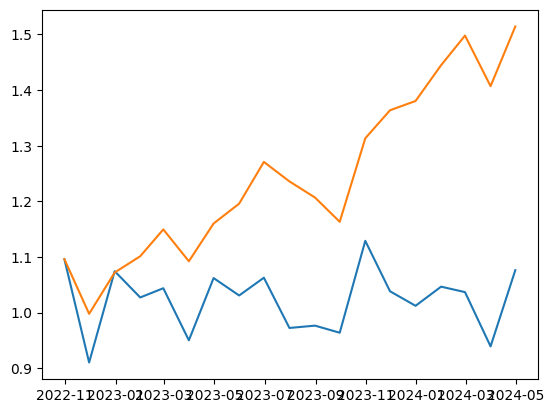

In [7]:
dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

In [8]:
# Losowe 10 spółek spośród 50 z największym zwrotem

def get_random_50(date, df, random_state=None):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top_10 = r3.loc[date, top50].sample(n=10, random_state=random_state).index
    return top_10

get_random_50('2023-02-28', df)

Index(['AZN', 'CSCO', 'CSGP', 'CTAS', 'AMGN', 'GFS', 'AAPL', 'CDW', 'ABNB',
       'AEP'],
      dtype='object')

In [9]:
def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_50(date,df)][1:2]) 

[1.1105118700807055, 0.9153888576653173, 1.1220252999820743, 0.9361217731105007, 1.0623118274578855, 0.9957411089078919, 0.9853600235061879, 1.0483252850318894, 1.0419424417175684, 0.9818742861152661, 0.9794402664515266, 0.9370339658564019, 1.07943583916405, 1.0616534234629411, 1.053243054948287, 1.0365487345978095, 1.018384288388867, 0.9762772499241142, 1.0470350312809826]


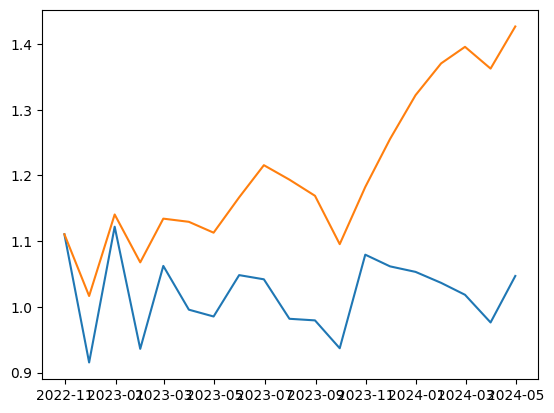

In [10]:
dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

[1.1644730038907347, 0.9099002548922549, 1.1290670592054561, 0.9814253064327675, 1.0516707338747975, 0.9511245658961958, 1.0581720408779314, 1.064583999069081, 1.0773326789747621, 0.9829863974292609, 0.9486932813155882, 0.9713646876304918, 1.1809544412807944, 1.041160795147499, 1.0541600310374224, 1.0900614156867392, 1.0519609719638439, 0.9458510875877384, 1.0441954931169157]


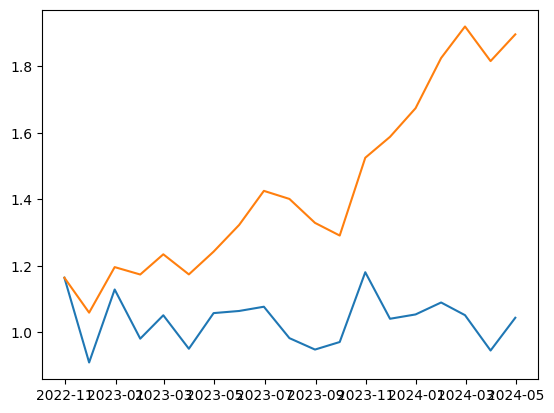

In [11]:
# Losowe 10 spółek spośród 30 z największym zwrotem

def get_random_30(date, df, random_state=None):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top_10 = r3.loc[date, top30].sample(n=10, random_state=random_state).index
    return top_10

def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_30(date,df)][1:2]) 


dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

[1.075651633265036, 0.9263079458826164, 1.071843626166616, 1.0341406976127665, 1.075514326351455, 0.9869380565266246, 1.0404601898807155, 1.087741976945392, 1.0806529384504664, 0.9602225596716039, 0.9573578491780133, 0.9413035953172285, 1.0709905402676256, 1.079370810571712, 0.9913626752962361, 1.0007243775376302, 0.9791338600505164, 0.9547122878369253, 1.047439642954884]


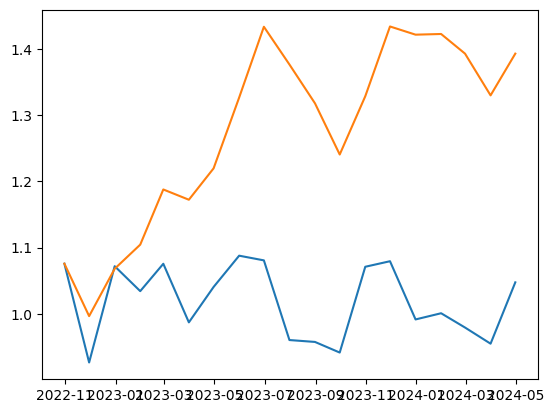

In [12]:
def get_random_10(date, df, random_state=None):
    top_10 = df.loc[date].sample(n=10, random_state=random_state).index
    return top_10

def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_10(date,df)][1:2]) 


dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

# 27.05.2024

## Wskaźniki AT

In [130]:
from ta import add_all_ta_features
from ta.utils import dropna

In [131]:
def portfolio_res(date, df):
  return np.proc()(df.loc[date:,get_random_10(date,df)][1:2]) 


### Pobranie danych

In [263]:
tickers = ['TSLA', 'MSFT', 'AMZN']

df = yf.download(tickers, start = '2021-01-01')
df.head()

[*********************100%***********************]  3 of 3 completed


Adj Close                               Close               
                  AMZN        MSFT        TSLA        AMZN        MSFT   
Date                                                                     
2021-01-04  159.331497  211.224304  243.256668  159.331497  217.690002  \
2021-01-05  160.925507  211.428070  245.036667  160.925507  217.899994   
2021-01-06  156.919006  205.945892  251.993332  156.919006  212.250000   
2021-01-07  158.108002  211.806488  272.013336  158.108002  218.289993   
2021-01-08  159.134995  213.097000  293.339996  159.134995  219.619995   

                              High                                 Low   
                  TSLA        AMZN        MSFT        TSLA        AMZN   
Date                                                                     
2021-01-04  243.256668  163.600006  223.000000  248.163330  157.201004  \
2021-01-05  245.036667  161.169006  218.520004  246.946671  158.253006   
2021-01-06  251.993332  159.875504  216.490005  258.000000  156.557999   
2021-01-07  272.013336  160.427002  219.339996  272.329987  157.750000   
2021-01-08  293.339996  159.531998  220.580002  294.829987  157.110001   

                                          Open                           
                  MSFT        TSLA        AMZN        MSFT        TSLA   
Date                                                                     
2021-01-04  214.809998  239.063339  163.500000  222.529999  239.820007  \
2021-01-05  215.699997  239.733337  158.300507  217.259995  241.220001   
2021-01-06  211.940002  249.699997  157.324005  212.169998  252.830002   
2021-01-07  213.710007  258.399994  157.850006  214.039993  259.209991   
2021-01-08  217.029999  279.463318  159.000000  218.679993  285.333344   

              Volume                       
                AMZN      MSFT       TSLA  
Date                                       
2021-01-04  88228000  37130100  145914600  
2021-01-05  53110000  23823000   96735600  
2021-01-06  87896000  35930700  134100000  
2021-01-07  70290000  27694500  154496700  
2021-01-08  70754000  22956200  225166500

In [264]:
df.Open

,AMZN,MSFT,TSLA
Date,,,
2021-01-04,163.500000,222.529999,239.820007
2021-01-05,158.300507,217.259995,241.220001
2021-01-06,157.324005,212.169998,252.830002
2021-01-07,157.850006,214.039993,259.209991
2021-01-08,159.000000,218.679993,285.333344
...,...,...,...
2024-05-20,184.339996,420.209991,177.559998
2024-05-21,182.300003,426.829987,175.509995
2024-05-22,183.880005,430.089996,182.850006


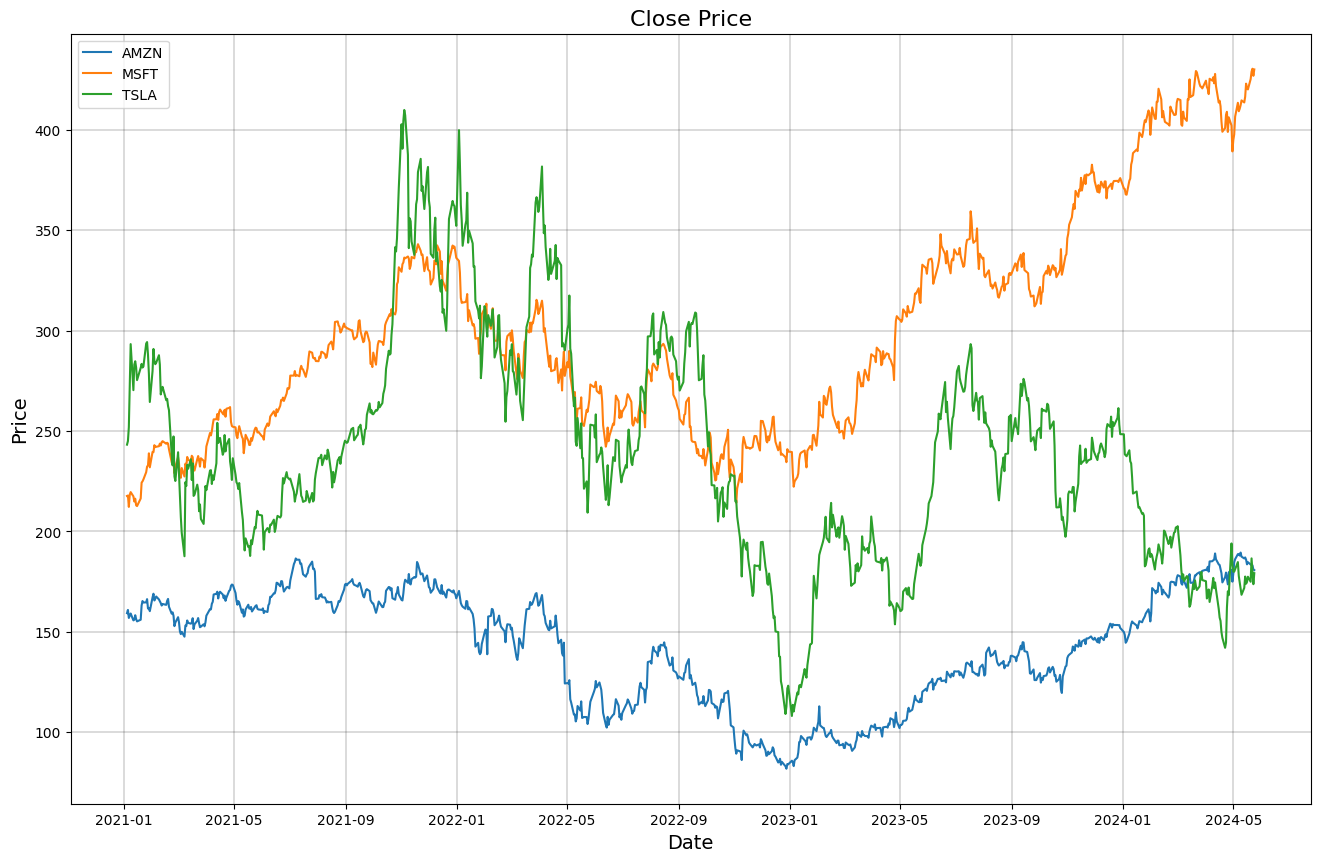

In [265]:
import matplotlib.pyplot as plt

close = df.Close

# Tworzenie wykresu
plt.figure(figsize=(16, 10))
for column in close:
    plt.plot(close.index, close[column], label=column)

plt.legend(loc='upper left')
plt.title("Close Price", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(which="major", color='k', linestyle='-', linewidth=0.2)
plt.show()

## Wskaźniki AT
RSI, Stochastic oscilator, EMA, MACD, ADX

In [266]:
# zmiana struktury danych
df.columns = df.columns.map('_'.join).str.strip('_')

unstack_df = df.stack().unstack(level=1)
unstack_df

,Adj Close_AMZN,Adj Close_MSFT,Adj Close_TSLA,Close_AMZN,Close_MSFT,Close_TSLA,High_AMZN,High_MSFT,High_TSLA,Low_AMZN,Low_MSFT,Low_TSLA,Open_AMZN,Open_MSFT,Open_TSLA,Volume_AMZN,Volume_MSFT,Volume_TSLA
Date,,,,,,,,,,,,,,,,,,
2021-01-04,159.331497,211.224304,243.256668,159.331497,217.690002,243.256668,163.600006,223.000000,248.163330,157.201004,214.809998,239.063339,163.500000,222.529999,239.820007,88228000.0,37130100.0,145914600.0
2021-01-05,160.925507,211.428070,245.036667,160.925507,217.899994,245.036667,161.169006,218.520004,246.946671,158.253006,215.699997,239.733337,158.300507,217.259995,241.220001,53110000.0,23823000.0,96735600.0
2021-01-06,156.919006,205.945892,251.993332,156.919006,212.250000,251.993332,159.875504,216.490005,258.000000,156.557999,211.940002,249.699997,157.324005,212.169998,252.830002,87896000.0,35930700.0,134100000.0
2021-01-07,158.108002,211.806488,272.013336,158.108002,218.289993,272.013336,160.427002,219.339996,272.329987,157.750000,213.710007,258.399994,157.850006,214.039993,259.209991,70290000.0,27694500.0,154496700.0
2021-01-08,159.134995,213.097000,293.339996,159.134995,219.619995,293.339996,159.531998,220.580002,294.829987,157.110001,217.029999,279.463318,159.000000,218.679993,285.333344,70754000.0,22956200.0,225166500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,183.539993,425.339996,174.949997,183.539993,425.339996,174.949997,186.669998,426.769989,177.750000,183.279999,419.989990,173.520004,184.339996,420.209991,177.559998,30511800.0,16272100.0,61727400.0
2024-05-21,183.149994,429.040009,186.600006,183.149994,429.040009,186.600006,183.259995,432.970001,186.880005,180.750000,424.850006,174.710007,182.300003,426.829987,175.509995,50839100.0,21453300.0,115266500.0
2024-05-22,183.130005,430.519989,180.110001,183.130005,430.519989,180.110001,185.220001,432.410004,183.800003,181.970001,427.130005,178.119995,183.880005,430.089996,182.850006,28148800.0,18073700.0,88313500.0


In [267]:
unstack_df.columns

Index(['Adj Close_AMZN', 'Adj Close_MSFT', 'Adj Close_TSLA', 'Close_AMZN',
       'Close_MSFT', 'Close_TSLA', 'High_AMZN', 'High_MSFT', 'High_TSLA',
       'Low_AMZN', 'Low_MSFT', 'Low_TSLA', 'Open_AMZN', 'Open_MSFT',
       'Open_TSLA', 'Volume_AMZN', 'Volume_MSFT', 'Volume_TSLA'],
      dtype='object')

In [268]:
for ticker in tickers:
    # RSI
    unstack_df[f'{ticker}_RSI'] = ta.momentum.RSIIndicator(close=unstack_df[f'Close_{ticker}']).rsi()
    
    # Stochastic Oscillator
    unstack_df[f'{ticker}_Stochastic'] = ta.momentum.StochasticOscillator(high=unstack_df[f'High_{ticker}'], low=unstack_df[f'Low_{ticker}'], close=unstack_df[f'Close_{ticker}']).stoch()
    
    # EMA (20-dniowa)
    unstack_df[f'{ticker}_EMA'] = ta.trend.EMAIndicator(close=unstack_df[f'Close_{ticker}'], window=20).ema_indicator()
    
    # MACD
    macd = ta.trend.MACD(close=unstack_df[f'Close_{ticker}'])
    unstack_df[f'{ticker}_MACD'] = macd.macd()
    unstack_df[f'{ticker}_MACD_Signal'] = macd.macd_signal()
    unstack_df[f'{ticker}_MACD_Diff'] = macd.macd_diff()
    
    # ADX (14-dniowy) 
    unstack_df[f'{ticker}_ADX'] = ta.trend.ADXIndicator(high=unstack_df[f'High_{ticker}'], low=unstack_df[f'Low_{ticker}'], close=unstack_df[f'Close_{ticker}'], window=14).adx()


In [269]:
unstack_df

,Adj Close_AMZN,Adj Close_MSFT,Adj Close_TSLA,Close_AMZN,Close_MSFT,Close_TSLA,High_AMZN,High_MSFT,High_TSLA,Low_AMZN,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,159.331497,211.224304,243.256668,159.331497,217.690002,243.256668,163.600006,223.000000,248.163330,157.201004,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2021-01-05,160.925507,211.428070,245.036667,160.925507,217.899994,245.036667,161.169006,218.520004,246.946671,158.253006,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2021-01-06,156.919006,205.945892,251.993332,156.919006,212.250000,251.993332,159.875504,216.490005,258.000000,156.557999,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2021-01-07,158.108002,211.806488,272.013336,158.108002,218.289993,272.013336,160.427002,219.339996,272.329987,157.750000,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2021-01-08,159.134995,213.097000,293.339996,159.134995,219.619995,293.339996,159.531998,220.580002,294.829987,157.110001,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,183.539993,425.339996,174.949997,183.539993,425.339996,174.949997,186.669998,426.769989,177.750000,183.279999,...,0.488432,2.330708,14.490393,50.102430,46.103012,184.230650,1.372768,1.709521,-0.336753,11.055639
2024-05-21,183.149994,429.040009,186.600006,183.149994,429.040009,186.600006,183.259995,432.970001,186.880005,180.750000,...,1.116386,2.511814,15.411530,49.341700,27.480849,184.127731,1.125784,1.592774,-0.466990,10.778283
2024-05-22,183.130005,430.519989,180.110001,183.130005,430.519989,180.110001,185.220001,432.410004,183.800003,181.970001,...,1.760867,2.577925,16.266873,49.300383,21.735210,184.032709,0.917854,1.457790,-0.539936,10.094482


In [270]:
# for ticker in price_data.Close:
#     # RSI
#     price_data[f'{ticker}_RSI'] = ta.momentum.RSIIndicator(close=price_data.Close[ticker]).rsi()
    
#     # Stochastic Oscillator (używamy tylko ceny zamknięcia)
#     price_data[f'{ticker}_Stochastic'] = ta.momentum.StochasticOscillator(high=price_data.High[ticker], low=price_data.Low[ticker], close=price_data.Close[ticker]).stoch()
    
#     # EMA (20-dniowa)
#     price_data[f'{ticker}_EMA'] = ta.trend.EMAIndicator(close=price_data.Close[ticker], window=20).ema_indicator()
    
#     # MACD
#     macd = ta.trend.MACD(close=price_data.Close[ticker])
#     price_data[f'{ticker}_MACD'] = macd.macd()
#     price_data[f'{ticker}_MACD_Signal'] = macd.macd_signal()
#     price_data[f'{ticker}_MACD_Diff'] = macd.macd_diff()
    
#     # ADX (14-dniowy) 
#     price_data[f'{ticker}_ADX'] = ta.trend.ADXIndicator(high=price_data.High[ticker], low=price_data.Low[ticker], close=price_data.Close[ticker], window=14).adx()



In [271]:
price_data=unstack_df.dropna()

In [272]:
price_data

,Adj Close_AMZN,Adj Close_MSFT,Adj Close_TSLA,Close_AMZN,Close_MSFT,Close_TSLA,High_AMZN,High_MSFT,High_TSLA,Low_AMZN,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,159.037003,228.068817,238.166672,159.037003,234.509995,238.166672,161.615997,237.929993,256.166656,158.613007,...,5.789423,-1.378596,42.366489,41.186832,3.239828,163.490722,0.417383,1.141045,-0.723662,16.753384
2021-02-23,159.725006,226.862854,232.946671,159.725006,233.270004,232.946671,160.236496,234.830002,237.869995,154.679993,...,5.333388,-1.824142,40.378722,42.877218,29.641670,163.132082,0.076864,0.928209,-0.851345,17.254911
2021-02-24,157.976501,228.107712,247.339996,157.976501,234.550003,247.339996,158.561493,235.199997,248.333328,156.268997,...,4.839709,-1.974714,38.422305,39.750326,23.263978,162.641075,-0.330282,0.676511,-1.006793,17.720614
2021-02-25,152.858002,222.700424,227.406662,152.858002,228.990005,227.406662,158.912994,234.589996,245.736664,152.388000,...,4.248579,-2.364521,36.868041,32.319858,2.855067,161.709353,-1.053821,0.330444,-1.384266,18.985414
2021-02-26,154.646500,225.997299,225.166672,154.646500,232.380005,225.166672,156.121994,235.369995,235.566666,151.835007,...,3.671758,-2.307284,35.169021,36.767657,17.127591,161.036701,-1.466015,-0.028847,-1.437167,20.265589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,183.539993,425.339996,174.949997,183.539993,425.339996,174.949997,186.669998,426.769989,177.750000,183.279999,...,0.488432,2.330708,14.490393,50.102430,46.103012,184.230650,1.372768,1.709521,-0.336753,11.055639
2024-05-21,183.149994,429.040009,186.600006,183.149994,429.040009,186.600006,183.259995,432.970001,186.880005,180.750000,...,1.116386,2.511814,15.411530,49.341700,27.480849,184.127731,1.125784,1.592774,-0.466990,10.778283
2024-05-22,183.130005,430.519989,180.110001,183.130005,430.519989,180.110001,185.220001,432.410004,183.800003,181.970001,...,1.760867,2.577925,16.266873,49.300383,21.735210,184.032709,0.917854,1.457790,-0.539936,10.094482


## Wybór kolumn ze wskaźnikami

In [274]:
# technical_indicators = ['RSI', 'Stochastic', 'EMA', 'MACD','ADX']
technical_indicators = ['_RSI', '_Stochastic', '_EMA', '_MACD', '_ADX']

# Filtrowanie kolumn
technical_columns = [col for col in price_data.columns if any(indicator in col for indicator in technical_indicators)]

# Tworzenie nowego DataFrame tylko z kolumnami technicznymi
technical_data = price_data[technical_columns]

# Wyświetlanie danych technicznych
technical_data


,TSLA_RSI,TSLA_Stochastic,TSLA_EMA,TSLA_MACD,TSLA_MACD_Signal,TSLA_MACD_Diff,TSLA_ADX,MSFT_RSI,MSFT_Stochastic,MSFT_EMA,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,30.738401,2.524958,269.344100,-3.877088,0.755238,-4.632326,20.900414,47.741790,15.367800,238.040216,...,5.789423,-1.378596,42.366489,41.186832,3.239828,163.490722,0.417383,1.141045,-0.723662,16.753384
2021-02-23,28.891452,30.816746,265.877679,-6.210204,-0.637851,-5.572353,23.304545,45.685740,26.091989,237.585910,...,5.333388,-1.824142,40.378722,42.877218,29.641670,163.132082,0.076864,0.928209,-0.851345,17.254911
2021-02-24,39.657834,47.540288,264.112185,-6.819186,-1.874118,-4.945068,24.549480,48.167245,33.448300,237.296776,...,4.839709,-1.974714,38.422305,39.750326,23.263978,162.641075,-0.330282,0.676511,-1.006793,17.720614
2021-02-25,32.352236,24.430962,260.616421,-8.808721,-3.261038,-5.547683,25.991256,39.685537,6.082195,236.505655,...,4.248579,-2.364521,36.868041,32.319858,2.855067,161.709353,-1.053821,0.330444,-1.384266,18.985414
2021-02-26,31.646721,21.834073,257.240254,-10.445778,-4.697986,-5.747792,27.460272,45.936480,24.657534,236.112736,...,3.671758,-2.307284,35.169021,36.767657,17.127591,161.036701,-1.466015,-0.028847,-1.437167,20.265589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,51.354430,36.345269,173.745636,1.358414,1.271867,0.086546,13.458513,61.334474,96.077913,414.070510,...,0.488432,2.330708,14.490393,50.102430,46.103012,184.230650,1.372768,1.709521,-0.336753,11.055639
2024-05-21,59.547559,95.154005,174.969862,2.202175,1.457929,0.744246,14.217042,63.870781,89.744280,415.496176,...,1.116386,2.511814,15.411530,49.341700,27.480849,184.127731,1.125784,1.592774,-0.466990,10.778283
2024-05-22,54.082822,62.392742,175.459399,2.320423,1.630428,0.689996,14.921390,64.863606,92.124684,416.927016,...,1.760867,2.577925,16.266873,49.300383,21.735210,184.032709,0.917854,1.457790,-0.539936,10.094482


### Stopy zwrotu

Liczymy na podstawie `close = df.Close` z podstawowych danych


In [276]:
# close = df.Close
close_ret = (close.pct_change()+1)[1:].resample("M").prod() # proste stopy zwrotu/ jeśli ln to sumujemy (.prod() - mnożymy)
close_ret.head()

,AMZN,MSFT,TSLA
Date,,,
2021-01-31,1.006141,1.065552,1.087370
2021-02-28,0.964672,1.001811,0.851260
2021-03-31,1.000372,1.014588,0.988793
2021-04-30,1.120663,1.069602,1.062147
2021-05-31,0.929530,0.990086,0.881287


# -----ffn-----

Log returns 
                 AMZN      MSFT      TSLA
Date                                    
2021-01-05  0.009955  0.000964  0.007291
2021-01-06 -0.025212 -0.026271  0.027995
2021-01-07  0.007549  0.028060  0.076448
2021-01-08  0.006475  0.006074  0.075481
2021-01-11 -0.021754 -0.009746 -0.081442

Correlation:


,AMZN,MSFT,TSLA
AMZN,1.00,0.67,0.43
MSFT,0.67,1.00,0.42
TSLA,0.43,0.42,1.00


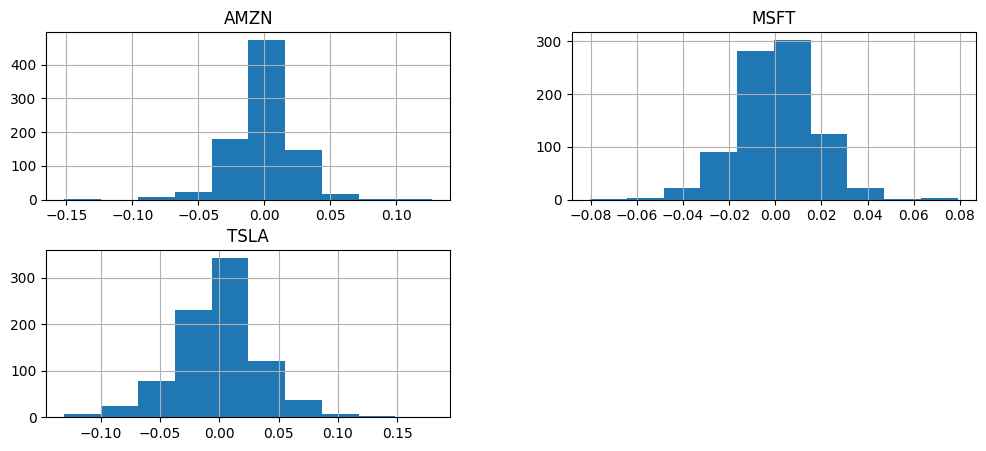

In [179]:
import ffn
close

returns = close.to_log_returns().dropna()
print(f'Log returns \n {returns.head()}')
ax = returns.hist(figsize=(12, 5))
print('\nCorrelation:')
returns.corr().as_format('.2f')

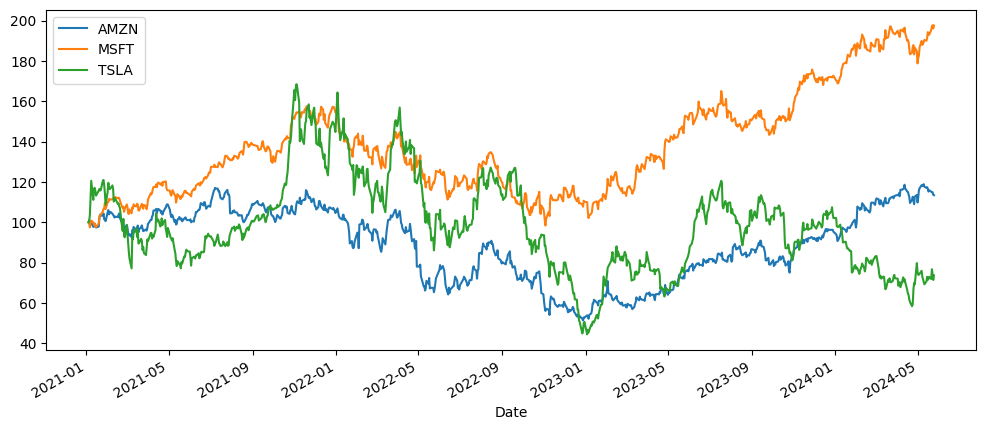

In [180]:
# equity?
ax = close.rebase().plot(figsize=(12,5))

Stat                 AMZN        MSFT        TSLA
-------------------  ----------  ----------  ----------
Start                2021-01-04  2021-01-04  2021-01-04
End                  2024-05-24  2024-05-24  2024-05-24
Risk-free rate       0.00%       0.00%       0.00%

Total Return         13.44%      97.60%      -26.32%
Daily Sharpe         0.28        0.88        0.14
Daily Sortino        0.47        1.52        0.23
CAGR                 3.80%       22.30%      -8.63%
Max Drawdown         -56.15%     -37.56%     -73.63%
Calmar Ratio         0.07        0.59        -0.12

MTD                  3.29%       10.49%      -2.20%
3m                   3.29%       4.83%       -6.63%
6m                   23.18%      13.97%      -23.87%
YTD                  18.96%      14.39%      -27.87%
1Y                   54.82%      37.06%      -2.00%
3Y (ann.)            3.66%       19.70%      -3.93%
5Y (ann.)            -           -           -
10Y (ann.)           -           -           -
Since Incep.

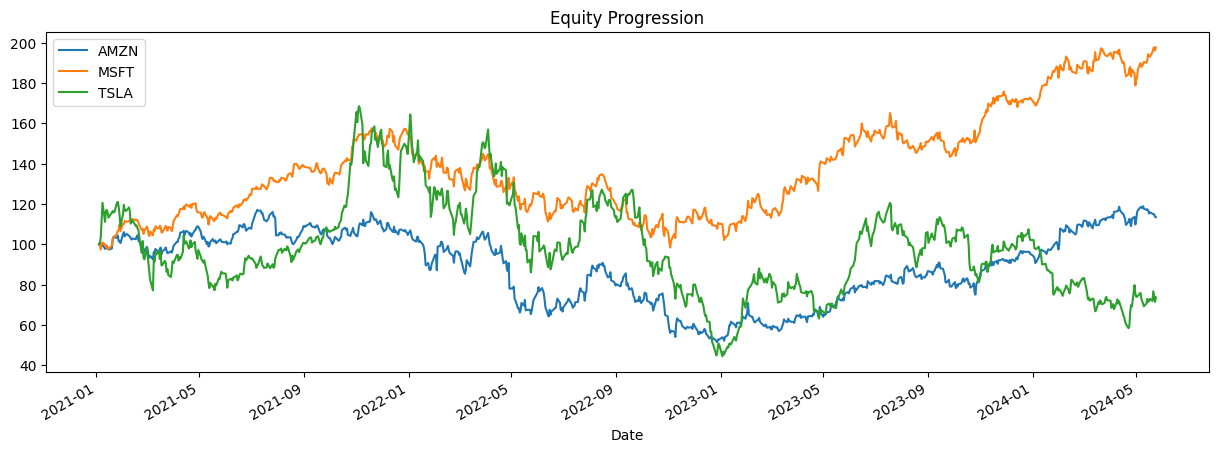

In [181]:
perf = close.calc_stats()
perf.plot()
print(perf.display())

In [182]:
returns.calc_mean_var_weights().as_format('.2%')

AMZN      0.00%
MSFT    100.00%
TSLA      0.00%
dtype: object

# ----------

In [278]:
# close_ret - zwroty
len(close_ret)

41

In [279]:
technical_data.head()

,TSLA_RSI,TSLA_Stochastic,TSLA_EMA,TSLA_MACD,TSLA_MACD_Signal,TSLA_MACD_Diff,TSLA_ADX,MSFT_RSI,MSFT_Stochastic,MSFT_EMA,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,30.738401,2.524958,269.344100,-3.877088,0.755238,-4.632326,20.900414,47.741790,15.367800,238.040216,...,5.789423,-1.378596,42.366489,41.186832,3.239828,163.490722,0.417383,1.141045,-0.723662,16.753384
2021-02-23,28.891452,30.816746,265.877679,-6.210204,-0.637851,-5.572353,23.304545,45.685740,26.091989,237.585910,...,5.333388,-1.824142,40.378722,42.877218,29.641670,163.132082,0.076864,0.928209,-0.851345,17.254911
2021-02-24,39.657834,47.540288,264.112185,-6.819186,-1.874118,-4.945068,24.549480,48.167245,33.448300,237.296776,...,4.839709,-1.974714,38.422305,39.750326,23.263978,162.641075,-0.330282,0.676511,-1.006793,17.720614
2021-02-25,32.352236,24.430962,260.616421,-8.808721,-3.261038,-5.547683,25.991256,39.685537,6.082195,236.505655,...,4.248579,-2.364521,36.868041,32.319858,2.855067,161.709353,-1.053821,0.330444,-1.384266,18.985414
2021-02-26,31.646721,21.834073,257.240254,-10.445778,-4.697986,-5.747792,27.460272,45.936480,24.657534,236.112736,...,3.671758,-2.307284,35.169021,36.767657,17.127591,161.036701,-1.466015,-0.028847,-1.437167,20.265589


#### Zmiana struktury DataFrame 'technical_data'

In [280]:
# technical_data.columns = technical_data.columns.map('_'.join).str.strip('_')

# unstack_technical_data = technical_data.stack().unstack(level=1)
# unstack_technical_data

#### Sprawdzanie, która klasa wag jest odpowiednia

Przygotuj dane 3 klasy wag:
	klasa 1: [0.2, 0.2, 0.6]
	klasa 2: [0.6, 0.2, 0.2]
	klasa 3: [0.2, 0.6, 0.2]
Wyucz las losowy na przygotowanych danych w okresie [2021-01-01 do 2023-12-31]
Wytestuj strategię w 2024 roku


In [281]:
# ZWROTY MIESIĘCZNE
# klasy wag
weights_classes = {
    "klasa 1": [0.2, 0.2, 0.6],
    "klasa 2": [0.6, 0.2, 0.2],
    "klasa 3": [0.2, 0.6, 0.2]
}

# spółki
companies = ['AMZN', 'MSFT', 'TSLA']


# wagi dla każdej spółki w każdej klasie wag
for company in companies:
    for class_name, weights in weights_classes.items():
        close_ret[company + '_' + class_name] = close_ret[company] * weights[0]
        
# suma wag dla każdej klasy
sum_weights = {class_name: close_ret[[company + '_' + class_name for company in companies]].sum().sum() for class_name in weights_classes.keys()}

# klasa z największą sumą wag
max_profit_class = max(sum_weights, key=sum_weights.get)

print(f"The class making the most profit is: {max_profit_class}")

The class making the most profit is: klasa 2


In [282]:
sum_weights

{'klasa 1': 24.876357185122792,
 'klasa 2': 74.62907155536837,
 'klasa 3': 24.876357185122792}

In [283]:
close_ret.head()

,AMZN,MSFT,TSLA,AMZN_klasa 1,AMZN_klasa 2,AMZN_klasa 3,MSFT_klasa 1,MSFT_klasa 2,MSFT_klasa 3,TSLA_klasa 1,TSLA_klasa 2,TSLA_klasa 3
Date,,,,,,,,,,,,
2021-01-31,1.006141,1.065552,1.087370,0.201228,0.603685,0.201228,0.213110,0.639331,0.213110,0.217474,0.652422,0.217474
2021-02-28,0.964672,1.001811,0.851260,0.192934,0.578803,0.192934,0.200362,0.601086,0.200362,0.170252,0.510756,0.170252
2021-03-31,1.000372,1.014588,0.988793,0.200074,0.600223,0.200074,0.202918,0.608753,0.202918,0.197759,0.593276,0.197759
2021-04-30,1.120663,1.069602,1.062147,0.224133,0.672398,0.224133,0.213920,0.641761,0.213920,0.212429,0.637288,0.212429
2021-05-31,0.929530,0.990086,0.881287,0.185906,0.557718,0.185906,0.198017,0.594052,0.198017,0.176257,0.528772,0.176257


### Podział na dane testowe i treningowe

In [284]:
# Data graniczna
split_date = '2024-01-01'

# Podział danych na treningowe i testowe
train_data = technical_data[technical_data.index < split_date]
test_data = technical_data[technical_data.index >= split_date]

In [285]:
train_data.head()

,TSLA_RSI,TSLA_Stochastic,TSLA_EMA,TSLA_MACD,TSLA_MACD_Signal,TSLA_MACD_Diff,TSLA_ADX,MSFT_RSI,MSFT_Stochastic,MSFT_EMA,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-22,30.738401,2.524958,269.344100,-3.877088,0.755238,-4.632326,20.900414,47.741790,15.367800,238.040216,...,5.789423,-1.378596,42.366489,41.186832,3.239828,163.490722,0.417383,1.141045,-0.723662,16.753384
2021-02-23,28.891452,30.816746,265.877679,-6.210204,-0.637851,-5.572353,23.304545,45.685740,26.091989,237.585910,...,5.333388,-1.824142,40.378722,42.877218,29.641670,163.132082,0.076864,0.928209,-0.851345,17.254911
2021-02-24,39.657834,47.540288,264.112185,-6.819186,-1.874118,-4.945068,24.549480,48.167245,33.448300,237.296776,...,4.839709,-1.974714,38.422305,39.750326,23.263978,162.641075,-0.330282,0.676511,-1.006793,17.720614
2021-02-25,32.352236,24.430962,260.616421,-8.808721,-3.261038,-5.547683,25.991256,39.685537,6.082195,236.505655,...,4.248579,-2.364521,36.868041,32.319858,2.855067,161.709353,-1.053821,0.330444,-1.384266,18.985414
2021-02-26,31.646721,21.834073,257.240254,-10.445778,-4.697986,-5.747792,27.460272,45.936480,24.657534,236.112736,...,3.671758,-2.307284,35.169021,36.767657,17.127591,161.036701,-1.466015,-0.028847,-1.437167,20.265589
